In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns
from scipy.stats import shapiro


from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [20]:
# zaladowanie danych

tickers = ['AAPL', 'MSFT', 'GOOG', 'NFLX', 'AMZN', 'TSLA']
start_date = '2015-01-01'
end_date = '2025-01-01'

def fetch_data(ticker):
    df = yf.download(ticker, interval='1d', start=start_date, end=end_date)
    df = df[['Close']].copy()
    df.rename(columns={'Close': f'{ticker}_Close'}, inplace=True)
    df.to_csv("data_output.txt", index=False)
    return df

data = fetch_data(tickers[0])
for ticker in tickers[1:]:
    data = data.join(fetch_data(ticker), how='outer')

data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price      AAPL_Close MSFT_Close GOOG_Close NFLX_Close AMZN_Close TSLA_Close
Ticker           AAPL       MSFT       GOOG       NFLX       AMZN       TSLA
Date                                                                        
2015-01-02  24.288574  39.998703  26.045292  49.848572    15.4260  14.620667
2015-01-05  23.604330  39.630882  25.502359  47.311428    15.1095  14.006000
2015-01-06  23.606556  39.049202  24.911291  46.501431    14.7645  14.085333
2015-01-07  23.937571  39.545349  24.868610  46.742859    14.9210  14.063333
2015-01-08  24.857304  40.708687  24.947023  47.779999    15.0230  14.041333

Original column structure:

Flattened column names:
AAPL


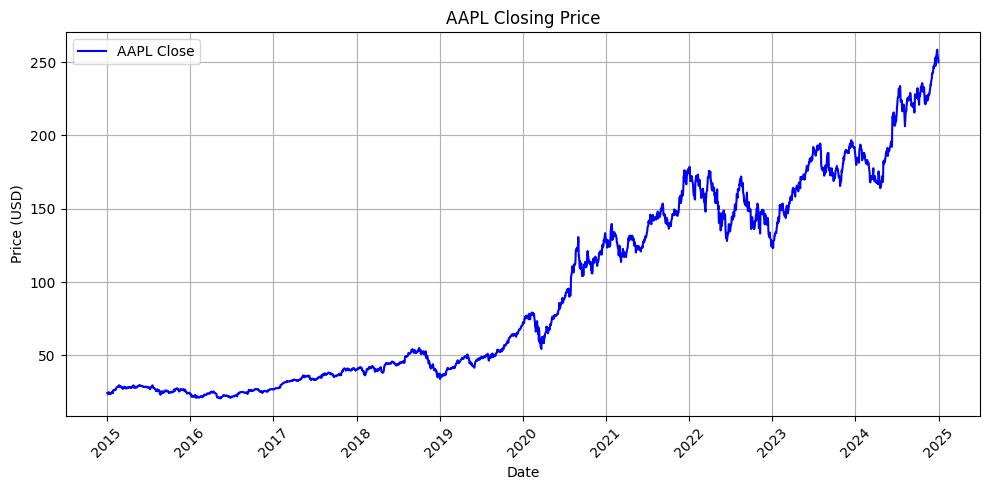

MSFT


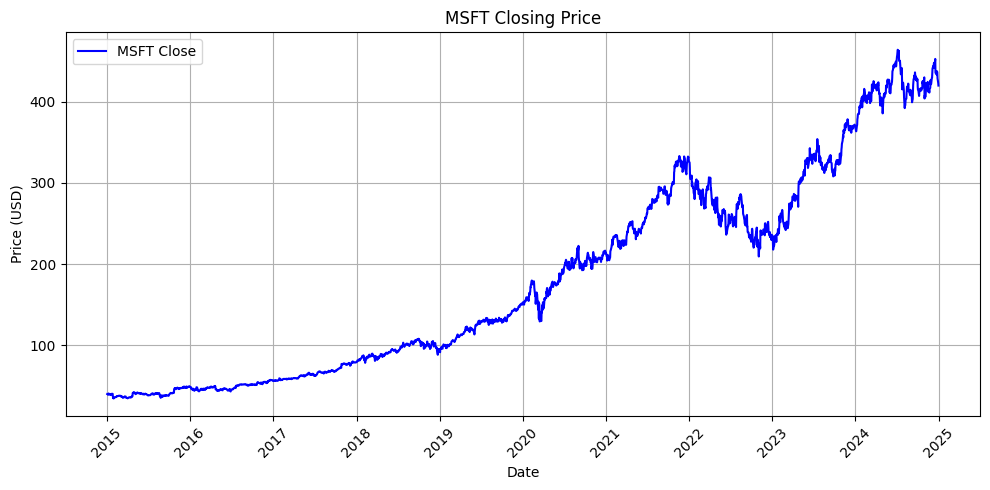

GOOG


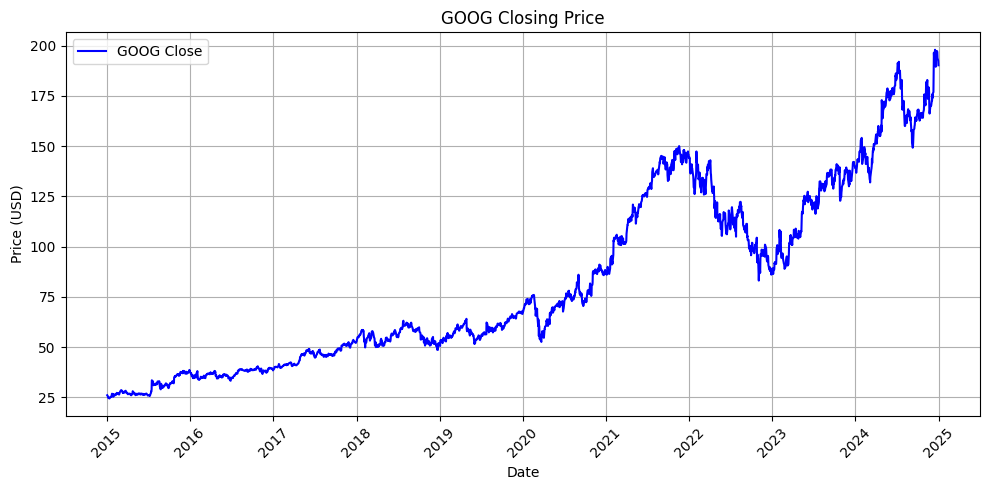

NFLX


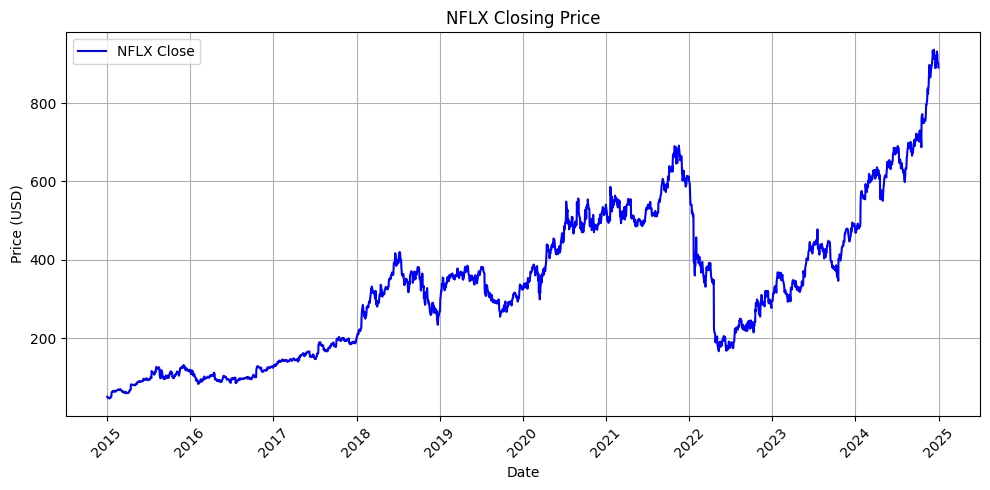

AMZN


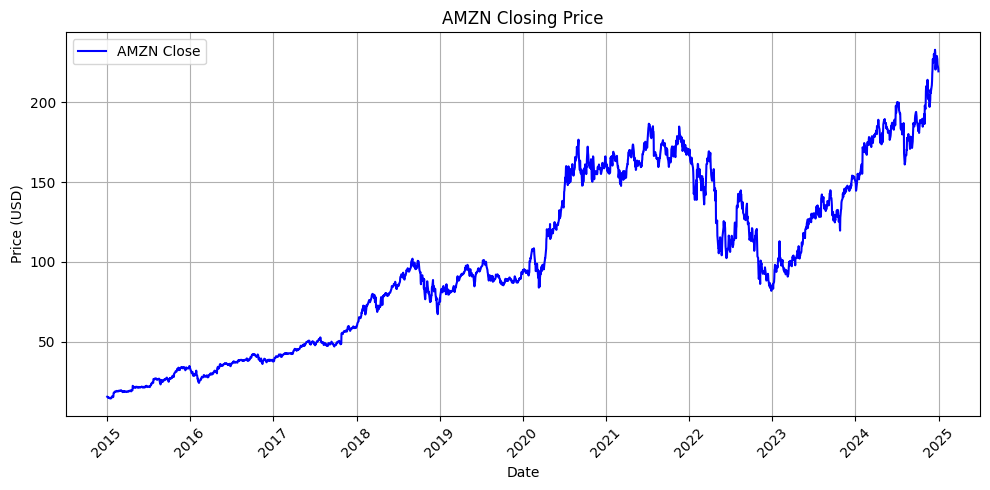

TSLA


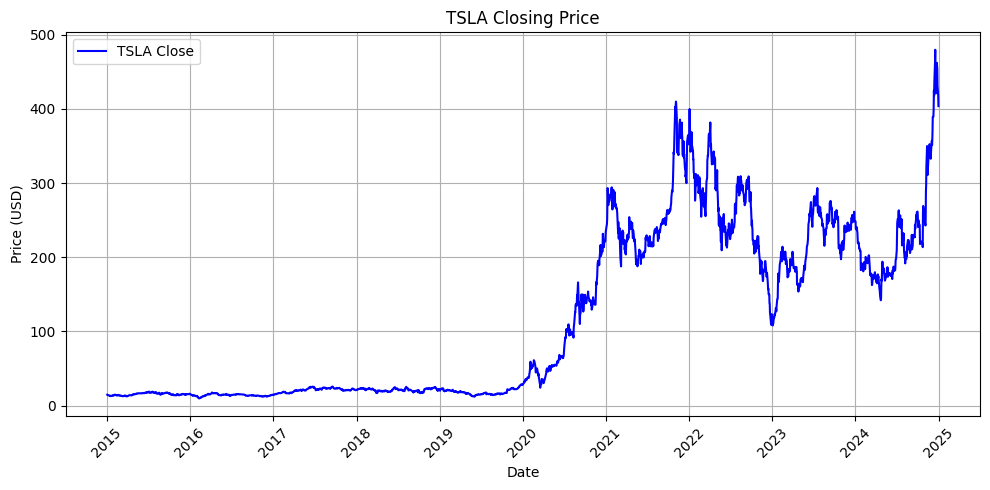

In [21]:
print("Original column structure:")
data.columns

u = data.copy()

data.columns = ['_'.join(col).strip() for col in data.columns.to_flat_index()]

print("\nFlattened column names:")

for ticker, column_name in zip(tickers, data.columns):
    print(ticker)
    
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column_name], linestyle='-', color='blue', label=f"{ticker} Close")
    plt.title(f'{ticker} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

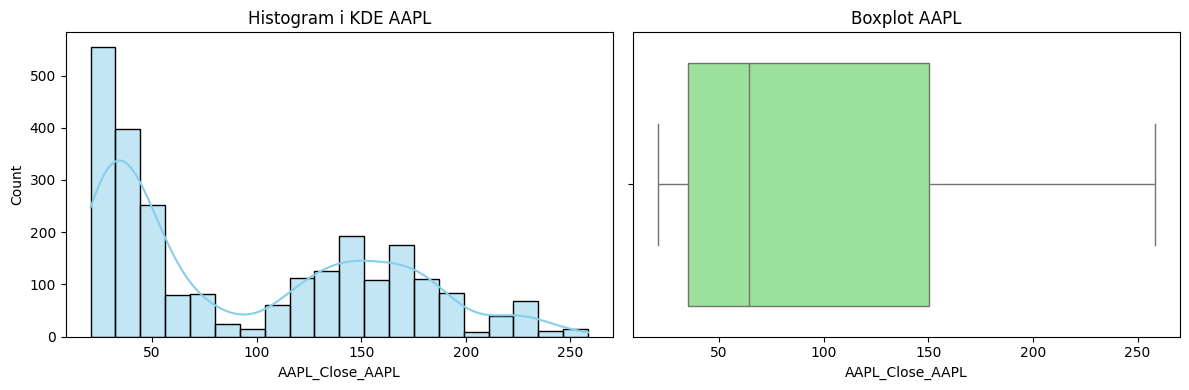

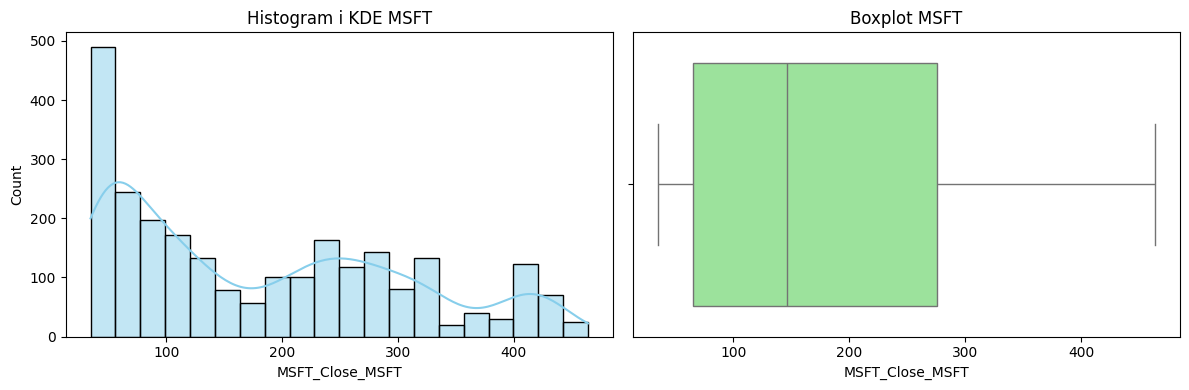

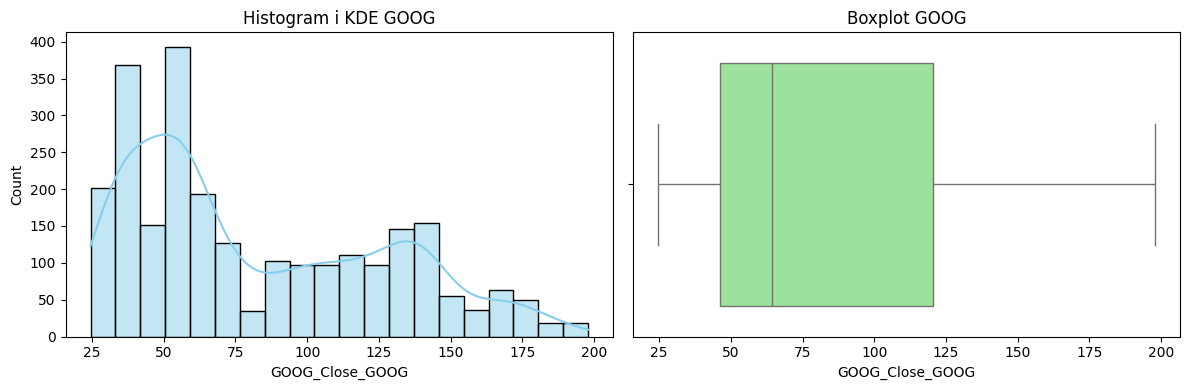

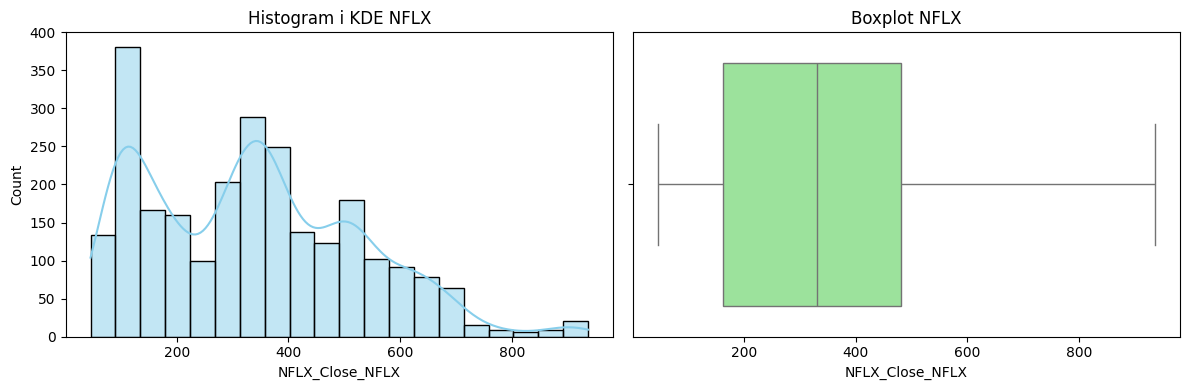

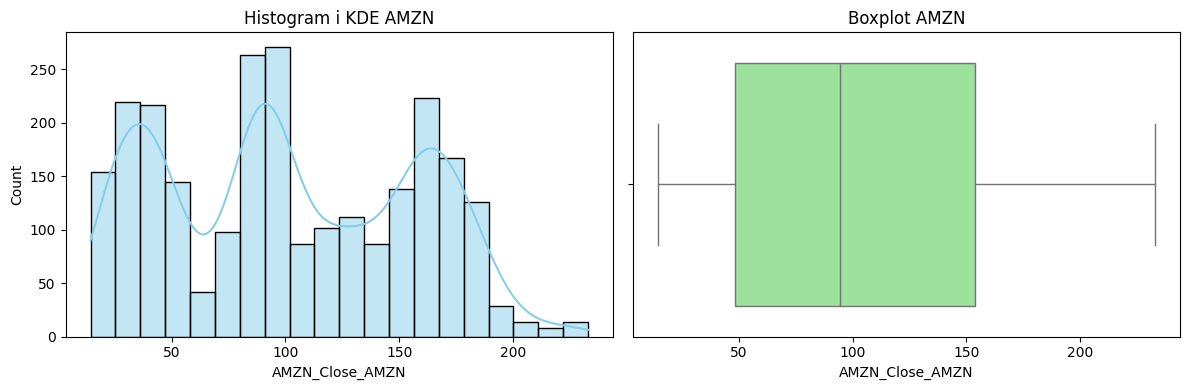

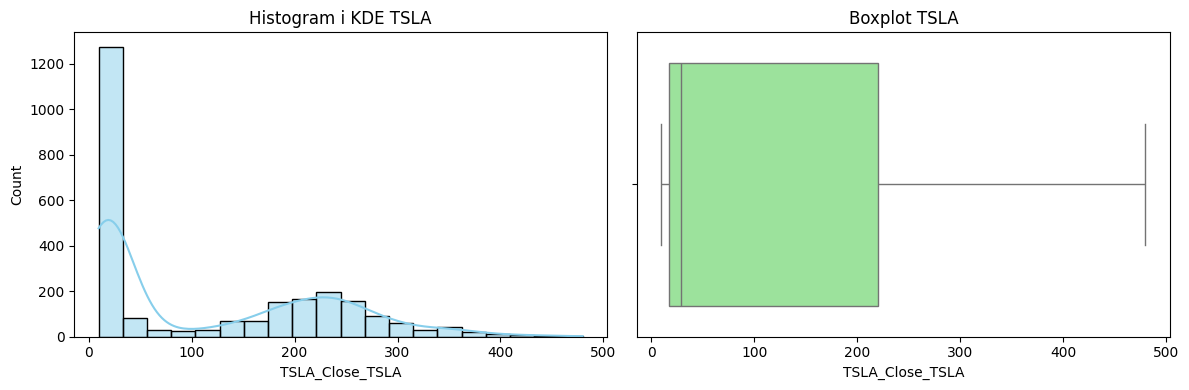

In [22]:
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    series = data[column_name]
    
    plt.figure(figsize=(12, 4))
    
    # Histogram + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(series, kde=True, bins=20, color='skyblue')
    plt.title(f"Histogram i KDE {ticker}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=series, color='lightgreen')
    plt.title(f"Boxplot {ticker}")
    
    plt.tight_layout()
    plt.show()

In [23]:
# test statystyczny normalnosci
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    print(ticker)
    print("----")
    series = data[column_name]
    stat, p = shapiro(series)
    print(f"Test Shapiro-Wilka:")
    print(f"Statystyka: {stat:.4f}, p-wartość: {p:.4f}")
    if p > 0.05:
        print("Rozkład wygląda na normalny.")
    else:
        print("Rozkład różni się od normalnego.")
        print("\n")

AAPL
----
Test Shapiro-Wilka:
Statystyka: 0.8726, p-wartość: 0.0000
Rozkład różni się od normalnego.


MSFT
----
Test Shapiro-Wilka:
Statystyka: 0.9041, p-wartość: 0.0000
Rozkład różni się od normalnego.


GOOG
----
Test Shapiro-Wilka:
Statystyka: 0.9109, p-wartość: 0.0000
Rozkład różni się od normalnego.


NFLX
----
Test Shapiro-Wilka:
Statystyka: 0.9554, p-wartość: 0.0000
Rozkład różni się od normalnego.


AMZN
----
Test Shapiro-Wilka:
Statystyka: 0.9479, p-wartość: 0.0000
Rozkład różni się od normalnego.


TSLA
----
Test Shapiro-Wilka:
Statystyka: 0.8085, p-wartość: 0.0000
Rozkład różni się od normalnego.




In [24]:
# podstawowe statystyki opisowe
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    print(ticker)
    print("-----")
    series = data[column_name]
    print("Podstawowe statystyki:")
    print("\nSkośność:", skew(series))
    print("Kurtoza:", kurtosis(series))
    print("\n")


AAPL
-----
Podstawowe statystyki:

Skośność: 0.5027483480550484
Kurtoza: -1.143966414596202


MSFT
-----
Podstawowe statystyki:

Skośność: 0.5401142084505993
Kurtoza: -0.9380314859615648


GOOG
-----
Podstawowe statystyki:

Skośność: 0.6168124333903512
Kurtoza: -0.8335487264688997


NFLX
-----
Podstawowe statystyki:

Skośność: 0.49364982431782584
Kurtoza: -0.3186494781545184


AMZN
-----
Podstawowe statystyki:

Skośność: 0.13638371100276792
Kurtoza: -1.1547738701054253


TSLA
-----
Podstawowe statystyki:

Skośność: 0.6480100997470751
Kurtoza: -0.9535165049687029




In [25]:
# preprocessing for predictions

def create_lag_features(df, ticker, lags=3):
    for i in range(1, lags + 1):
        df[f'{ticker}_lag_{i}'] = df[f'{ticker}_Close'].shift(i)
    return df

for ticker in tickers:
    data = create_lag_features(u, ticker)
    pass

u.dropna(inplace=True)
u.head(n=20)


Price      AAPL_Close MSFT_Close GOOG_Close NFLX_Close AMZN_Close TSLA_Close  \
Ticker           AAPL       MSFT       GOOG       NFLX       AMZN       TSLA   
Date                                                                           
2015-01-07  23.937571  39.545349  24.868610  46.742859  14.921000  14.063333   
2015-01-08  24.857304  40.708687  24.947023  47.779999  15.023000  14.041333   
2015-01-09  24.883970  40.366524  24.623947  47.041428  14.846500  13.777333   
2015-01-12  24.270805  39.861832  24.444290  45.547142  14.570500  13.480667   
2015-01-13  24.486300  39.656544  24.624441  46.255714  14.737000  13.616667   
2015-01-14  24.392996  39.314369  24.857197  46.320000  14.663500  12.846000   
2015-01-15  23.730959  38.903790  24.902853  46.251431  14.347500  12.791333   
2015-01-16  23.546568  39.553890  25.215014  48.191429  14.537000  12.871333   
2015-01-20  24.153061  39.682209  25.156454  49.828571  14.472000  12.795333   
2015-01-21  24.337458  39.280159  25.709312  58.468571  14.862500  13.104667   
2015-01-22  24.970608  40.315193  26.520727  61.205715  15.516000  13.441333   
2015-01-23  25.099463  40.357971  26.796658  62.494286  15.619500  13.419333   
2015-01-26  25.126120  40.212555  26.561422  63.794285  15.483000  13.770000   
2015-01-27  24.246370  36.491550  25.738590  64.881432  15.337500  13.732000   
2015-01-28  25.617085  35.234097  25.310299  63.208572  15.195500  13.291333   
2015-01-29  26.414635  35.935528  25.343056  63.400002  15.589000  13.680000   
2015-01-30  26.028084  34.558331  26.527180  63.114285  17.726500  13.573333   
2015-02-02  26.354652  35.311092  26.227427  63.009998  18.223499  14.062667   
2015-02-03  26.359095  35.584812  26.265144  65.274284  18.177500  14.557333   
2015-02-04  26.561251  35.790112  25.943554  64.101433  18.237499  14.570000   

Price      AAPL_lag_1 AAPL_lag_2 AAPL_lag_3 MSFT_lag_1  ... GOOG_lag_3  \
Ticker                                                  ...              
Date                                                    ...              
2015-01-07  23.606556  23.604330  24.288574  39.049202  ...  26.045292   
2015-01-08  23.937571  23.606556  23.604330  39.545349  ...  25.502359   
2015-01-09  24.857304  23.937571  23.606556  40.708687  ...  24.911291   
2015-01-12  24.883970  24.857304  23.937571  40.366524  ...  24.868610   
2015-01-13  24.270805  24.883970  24.857304  39.861832  ...  24.947023   
2015-01-14  24.486300  24.270805  24.883970  39.656544  ...  24.623947   
2015-01-15  24.392996  24.486300  24.270805  39.314369  ...  24.444290   
2015-01-16  23.730959  24.392996  24.486300  38.903790  ...  24.624441   
2015-01-20  23.546568  23.730959  24.392996  39.553890  ...  24.857197   
2015-01-21  24.153061  23.546568  23.730959  39.682209  ...  24.902853   
2015-01-22  24.337458  24.153061  23.546568  39.280159  ...  25.215014   
2015-01-23  24.970608  24.337458  24.153061  40.315193  ...  25.156454   
2015-01-26  25.099463  24.970608  24.337458  40.357971  ...  25.709312   
2015-01-27  25.126120  25.099463  24.970608  40.212555  ...  26.520727   
2015-01-28  24.246370  25.126120  25.099463  36.491550  ...  26.796658   
2015-01-29  25.617085  24.246370  25.126120  35.234097  ...  26.561422   
2015-01-30  26.414635  25.617085  24.246370  35.935528  ...  25.738590   
2015-02-02  26.028084  26.414635  25.617085  34.558331  ...  25.310299   
2015-02-03  26.354652  26.028084  26.414635  35.311092  ...  25.343056   
2015-02-04  26.359095  26.354652  26.028084  35.584812  ...  26.527180   

Price      NFLX_lag_1 NFLX_lag_2 NFLX_lag_3 AMZN_lag_1 AMZN_lag_2 AMZN_lag_3  \
Ticker                                                                         
Date                                                                           
2015-01-07  46.501431  47.311428  49.848572  14.764500  15.109500    15.4260   
2015-01-08  46.742859  46.501431  47.311428  14.921000  14.764500    15.1095   
2015-01-09  47.779999  46.742859  46.501431  15.023000  

AAPL
MAE: 14.28
RMSE: 24.23


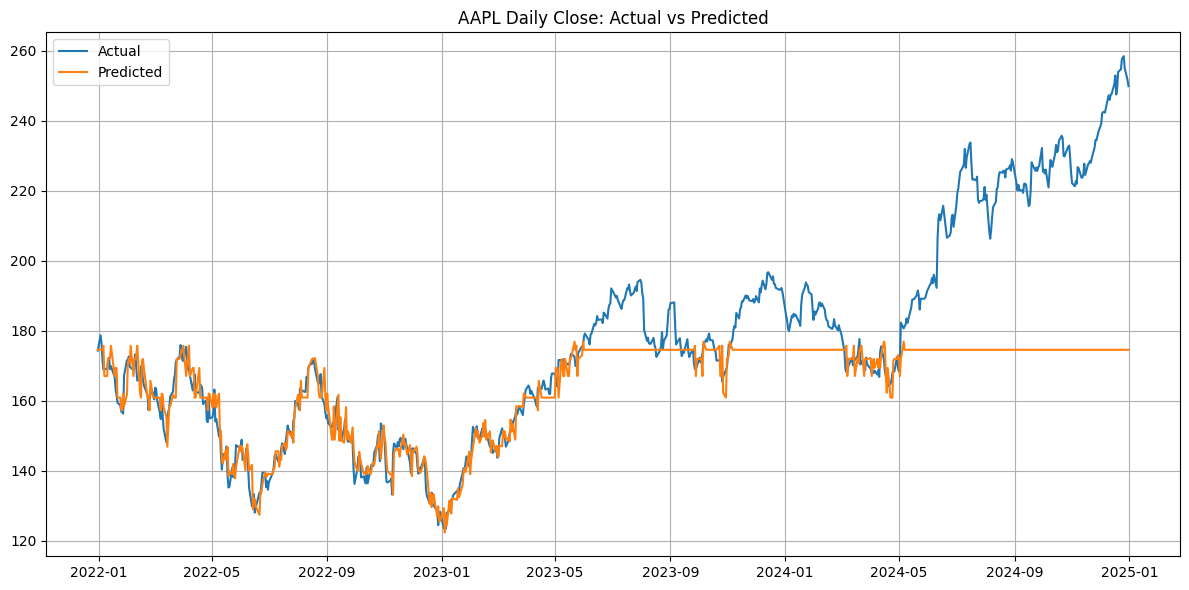

MSFT
MAE: 34.34
RMSE: 52.37


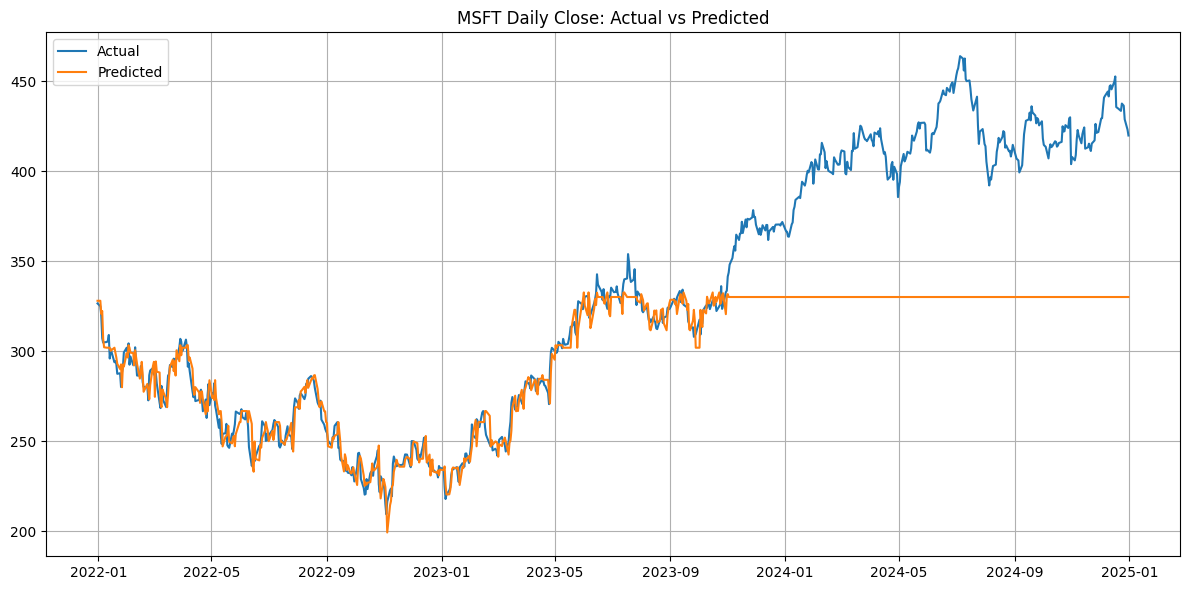

GOOG
MAE: 7.99
RMSE: 13.62


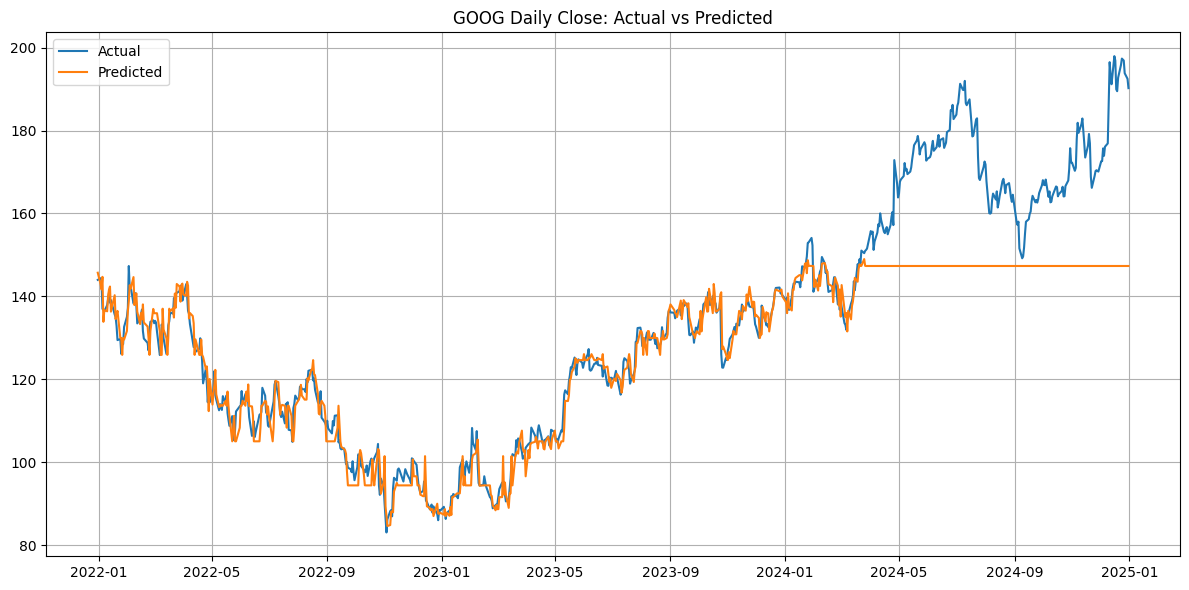

NFLX
MAE: 20.50
RMSE: 48.86


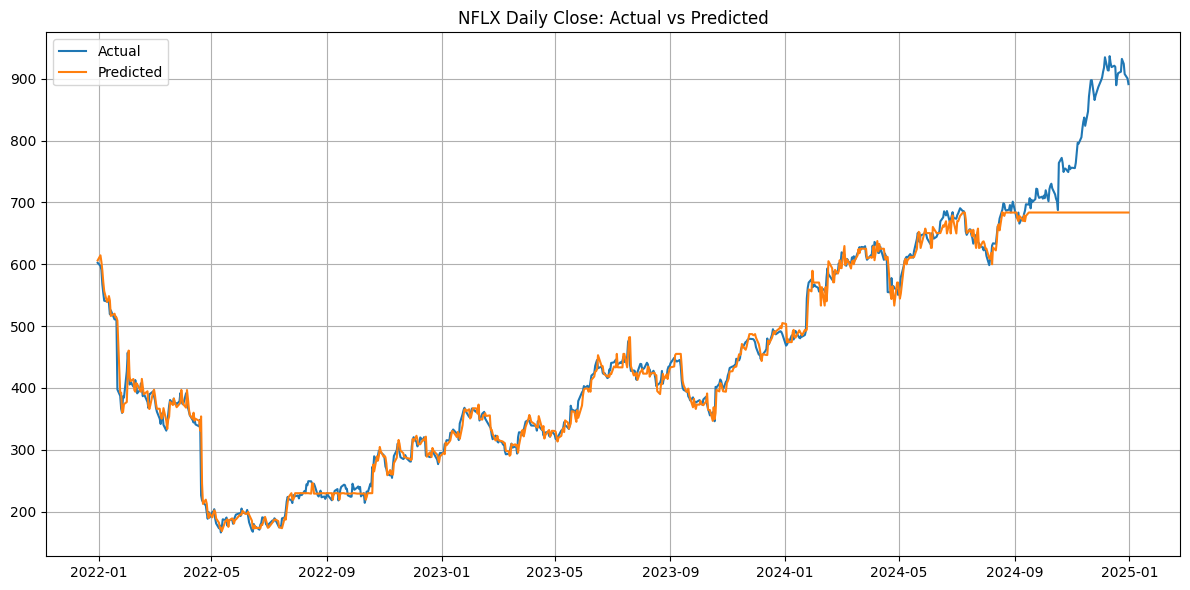

AMZN
MAE: 5.38
RMSE: 9.19


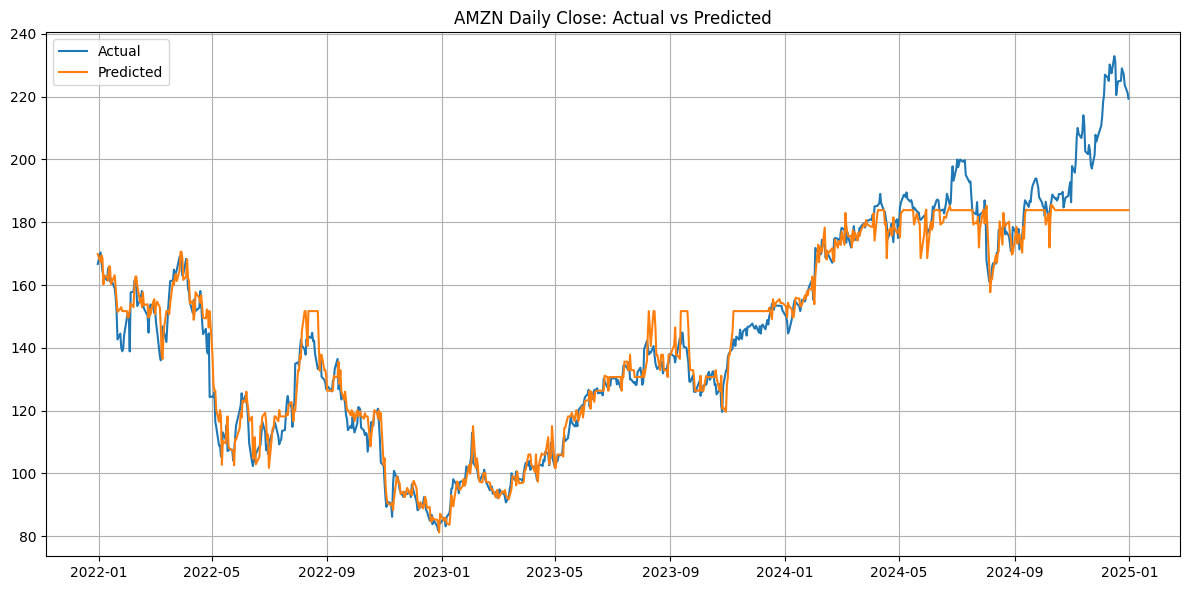

TSLA
MAE: 10.37
RMSE: 14.74


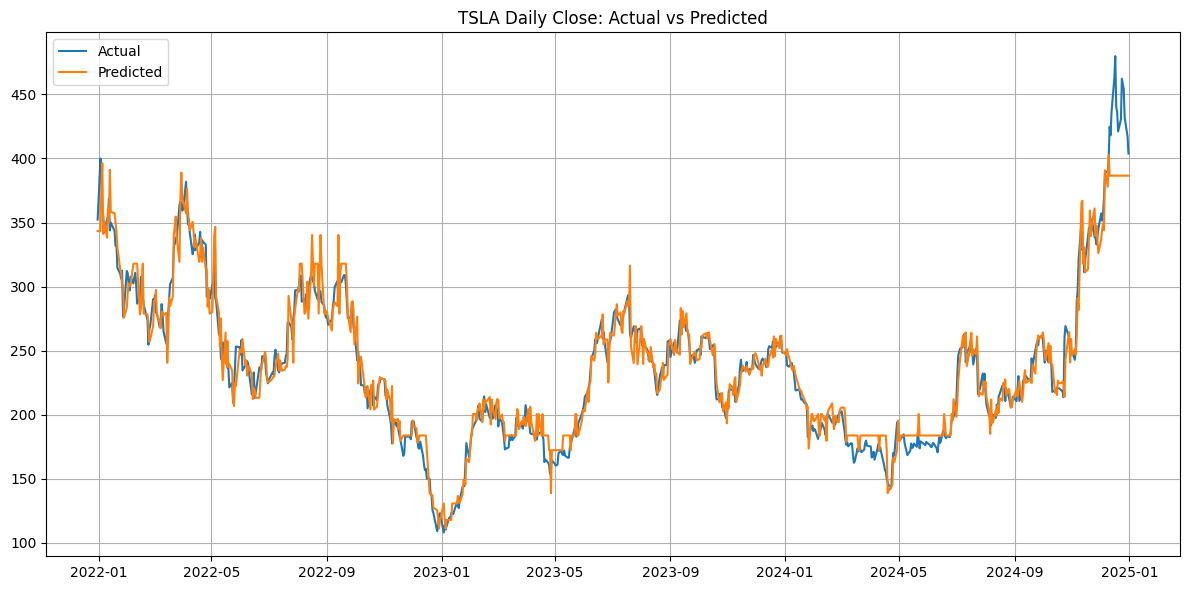

In [26]:
for ticker in tickers:
    print(ticker)

    target = f'{ticker}_Close'
    features = [f'{ticker}_lag_{i}' for i in range(1, 4)]
    
    X = u[features]
    y = u[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{ticker} Daily Close: Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()